In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/plant-seedlings/"

In [4]:
sz = 224
arch = resnet50
bs = 32
# try 224, 58 and 299, 58

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [6]:
label_df = pd.read_csv(label_csv)

## Removing space between class names

In [ ]:
label_df.species = label_df.species.apply(lambda x: re.sub(' ', '_', x))
label_df.to_csv(f'{PATH}labels.csv', index=False)

## Pivot table

In [ ]:
label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

## Analysis

In [ ]:
row_sz = [PIL.Image.open(f'{PATH}train/'+k).size[0] for k in os.listdir(f'{PATH}train/')]

In [ ]:
col_sz = [PIL.Image.open(f'{PATH}train/'+k).size[1] for k in os.listdir(f'{PATH}train/')]

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
plt.hist(row_sz[row_sz < 500]);

In [ ]:
plt.hist(col_sz[col_sz < 500]);

## Training setup

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [9]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


In [10]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 97/119 [00:05<00:01, 17.32it/s, loss=8.71]


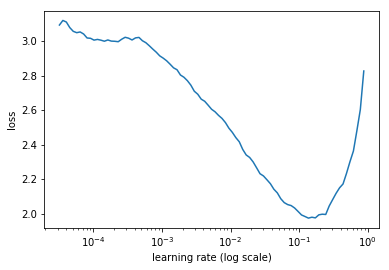

In [11]:
learn.sched.plot()

In [12]:
lr = 1e-2

In [13]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.09971  0.71199  0.75928]                       
[ 1.       0.7753   0.55735  0.81288]                        
[ 2.       0.61652  0.49996  0.82794]                        



In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [15]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.23292  0.79276  0.76079]                       
[ 1.       0.85645  0.59552  0.80398]                        



In [16]:
learn.precompute=False
learn.bn_freeze=True

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.80742  0.5418   0.82377]                        
[ 1.       0.70653  0.50478  0.81288]                        
[ 2.       0.64418  0.45113  0.83778]                        
[ 3.       0.63899  0.43177  0.83684]                        
[ 4.       0.58851  0.43323  0.85975]                        
[ 5.       0.52201  0.39314  0.86439]                        
[ 6.       0.49172  0.40498  0.86278]                        



In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 100/119 [01:24<00:16,  1.19it/s, loss=4.17]

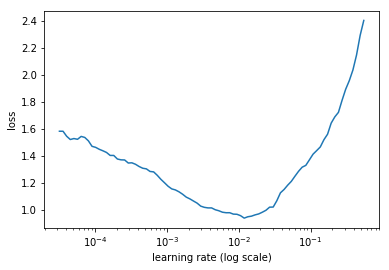

In [20]:
learn.sched.plot()

In [21]:
lrs = np.array([lr/18,lr/6,lr/2])

In [22]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))


  4%|▍         | 5/119 [00:05<02:08,  1.13s/it, loss=1.49]


Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.40919  0.24424  0.90786]                        
[ 1.       0.28543  0.17255  0.93494]                        
[ 2.       0.18043  0.14819  0.93911]                        
[ 3.       0.19327  0.18594  0.93494]                        
[ 4.       0.13809  0.13545  0.95057]                        
[ 5.       0.09657  0.13075  0.95369]                         
[ 6.       0.06987  0.13008  0.95265]                         



In [23]:
learn.save(f'{sz}')

In [24]:
sz = 299

In [25]:
learn.set_data(get_data(sz, bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [26]:
learn.freeze()
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.07356  0.15266  0.95057]                         
[ 1.      0.0772  0.1372  0.9589]                             



In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 57%|█████▋    | 68/119 [01:51<01:23,  1.64s/it, loss=0.301] 

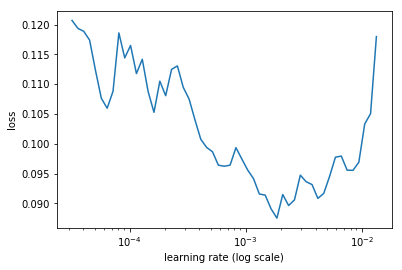

In [29]:
learn.sched.plot()

In [30]:
lrs = np.array([lr/18,lr/6,lr/2])

In [31]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))


  2%|▏         | 2/119 [00:04<04:41,  2.41s/it, loss=0.0918]


Exception in thread Thread-40:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-41:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.08753  0.13843  0.95322]                         
[ 1.       0.0983   0.12262  0.95578]                         
[ 2.       0.06267  0.11859  0.95786]                         
[ 3.       0.07371  0.16742  0.94536]                         
[ 4.       0.05483  0.17605  0.94697]                         
[ 5.       0.0421   0.13675  0.9589 ]                         
[ 6.       0.0344   0.13276  0.9589 ]                         



In [32]:
sz = 400

In [33]:
from sklearn import metrics

In [34]:
learn.set_data(get_data(sz, bs))

In [35]:
learn.freeze()
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.05116  0.22354  0.92557]                         
[ 1.       0.05479  0.19637  0.93551]                         



In [36]:
learn.unfreeze()

In [37]:
lrs

array([ 0.00056,  0.00167,  0.005  ])

In [38]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.06956  0.15939  0.95833]                         
[ 1.       0.06581  0.12742  0.95833]                         
[ 2.       0.05059  0.12609  0.96146]                         
[ 3.       0.07209  0.2465   0.92973]                         
[ 4.       0.04677  0.15726  0.95369]                         
[ 5.       0.02515  0.11711  0.96354]                         
[ 6.       0.01794  0.11218  0.96203]                         



In [ ]:
sz = 224

In [ ]:
learn.set_data(get_data(sz, 58))

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz = 299

In [ ]:
learn.set_data(get_data(sz, 58))

In [ ]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [ ]:
learn.fit(lr, 2, cycle_len=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.load(f'{sz}')

## Old steps

In [ ]:
learn.set_data(get_data(299, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('299_r50')

In [ ]:
learn.load('299_r50')

In [ ]:
learn.set_data(get_data(350, bs))
learn.freeze()

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('350_r50')

In [ ]:
learn.load('350_r50')

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)

In [ ]:
accuracy(log_preds, y)

In [ ]:
metrics.f1_score()

In [ ]:
learn.save('350_r50')

## Prediction

In [39]:
log_preds, y = learn.TTA(is_test=True)
probs_400 = np.exp(log_preds)

In [40]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()

In [41]:
save_array('probs_400.bc', probs_400)

## Save to file for submission

In [9]:
def load_array(fname): return bcolz.open(fname)[:]

In [10]:
probs_450 = load_array('probs_450.bc')

In [51]:
probs_299 = load_array('probs_299.bc')

In [52]:
probs = (probs_299 + probs_400) / 2

In [11]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

In [17]:
probs_450

array([[ 0.0002 ,  0.00003,  0.00018, ...,  0.     ,  0.     ,  0.99607],
       [ 0.     ,  0.98528,  0.00002, ...,  0.00075,  0.     ,  0.00048],
       [ 0.     ,  0.00034,  0.99909, ...,  0.00014,  0.00003,  0.00007],
       ..., 
       [ 0.20456,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.00001],
       [ 0.00001,  0.     ,  0.00019, ...,  0.00216,  0.     ,  0.     ],
       [ 0.     ,  0.00001,  0.     , ...,  0.00063,  0.     ,  0.00003]], dtype=float32)

In [22]:
probs_450[0].sum()

0.99799913

In [12]:
df = pd.DataFrame(probs)

In [13]:
df.insert(0, 'file', [o[5:-4] for o in data.test_ds.fnames])

In [14]:
df

,file,0,1,2,3,4,5,6,7,8,9,10,11
0,780bd2a2c,2.002403e-04,2.739903e-05,1.815911e-04,3.639636e-05,4.021390e-04,9.684090e-04,7.466439e-05,3.575061e-05,1.491416e-06,1.272974e-06,3.324062e-07,9.960694e-01
1,338c7e907,1.438897e-07,9.852843e-01,2.322737e-05,3.798559e-04,3.887816e-07,4.409562e-07,4.159323e-07,2.387754e-05,5.629167e-04,7.532219e-04,4.016574e-06,4.802964e-04
2,4bbfd1e05,7.073446e-07,3.421365e-04,9.990889e-01,4.323358e-07,4.285026e-06,5.607207e-07,3.567475e-06,3.202266e-07,1.561770e-04,1.386838e-04,3.343851e-05,6.561938e-05
3,6edb96d45,1.141046e-06,2.758865e-05,9.989071e-01,2.043162e-07,8.765603e-06,1.468585e-05,5.759759e-07,1.221551e-06,1.071298e-05,4.210779e-06,5.047170e-06,1.804133e-04
4,a8388a37f,3.173051e-04,1.749437e-07,2.244570e-05,2.603562e-06,2.869543e-03,9.923124e-01,9.743795e-05,2.079254e-05,5.511708e-08,1.788302e-07,5.381704e-06,2.736054e-05
5,2a667e099,6.296340e-06,1.138117e-07,5.049233e-05,3.067106e-05,2.513310e-05,9.993845e-01,2.606078e-06,1.376741e-06,1.132732e-07,6.163141e-07,6.573347e-06,3.282257e-05
6,8b9144917,1.029564e-07,4.284172e-06,2.028093e-04,7.220469e-06,9.033870e-08,2.318664e-05,3.670915e-07,1.181593e-05,2.974072e-06,3.357038e-04,9.931080e-01,3.405756e-07
7,44e8b8833,2.704504e-08,4.060110e-07,4.225823e-05,2.465675e-06,5.560980e-08,4.586582e-06,5.730559e-08,1.486169e-05,1.611827e-06,2.906876e-05,9.993473e-01,3.979259e-08
8,a2d25b4f3,6.329944e-05,5.844950e-06,5.229062e-03,8.664597e-04,1.154139e-05,2.947022e-04,1.463949e-04,3.156987e-04,1.196293e-03,6.169014e-04,9.651045e-01,9.022359e-06
9,e783f5a4f,6.453557e-06,2.828518e-06,2.316864e-06,4.473061e-04,1.551100e-06,1.731479e-06,2.966136e-06,9.439809e-06,3.764709e-07,1.101380e-07,2.781017e-09,9.989881e-01


In [15]:
df.columns = ['file', *data.classes]

In [16]:
df

,file,Black-grass,Charlock,Cleavers,Common_Chickweed,Common_wheat,Fat_Hen,Loose_Silky-bent,Maize,Scentless_Mayweed,Shepherds_Purse,Small-flowered_Cranesbill,Sugar_beet
0,780bd2a2c,2.002403e-04,2.739903e-05,1.815911e-04,3.639636e-05,4.021390e-04,9.684090e-04,7.466439e-05,3.575061e-05,1.491416e-06,1.272974e-06,3.324062e-07,9.960694e-01
1,338c7e907,1.438897e-07,9.852843e-01,2.322737e-05,3.798559e-04,3.887816e-07,4.409562e-07,4.159323e-07,2.387754e-05,5.629167e-04,7.532219e-04,4.016574e-06,4.802964e-04
2,4bbfd1e05,7.073446e-07,3.421365e-04,9.990889e-01,4.323358e-07,4.285026e-06,5.607207e-07,3.567475e-06,3.202266e-07,1.561770e-04,1.386838e-04,3.343851e-05,6.561938e-05
3,6edb96d45,1.141046e-06,2.758865e-05,9.989071e-01,2.043162e-07,8.765603e-06,1.468585e-05,5.759759e-07,1.221551e-06,1.071298e-05,4.210779e-06,5.047170e-06,1.804133e-04
4,a8388a37f,3.173051e-04,1.749437e-07,2.244570e-05,2.603562e-06,2.869543e-03,9.923124e-01,9.743795e-05,2.079254e-05,5.511708e-08,1.788302e-07,5.381704e-06,2.736054e-05
5,2a667e099,6.296340e-06,1.138117e-07,5.049233e-05,3.067106e-05,2.513310e-05,9.993845e-01,2.606078e-06,1.376741e-06,1.132732e-07,6.163141e-07,6.573347e-06,3.282257e-05
6,8b9144917,1.029564e-07,4.284172e-06,2.028093e-04,7.220469e-06,9.033870e-08,2.318664e-05,3.670915e-07,1.181593e-05,2.974072e-06,3.357038e-04,9.931080e-01,3.405756e-07
7,44e8b8833,2.704504e-08,4.060110e-07,4.225823e-05,2.465675e-06,5.560980e-08,4.586582e-06,5.730559e-08,1.486169e-05,1.611827e-06,2.906876e-05,9.993473e-01,3.979259e-08
8,a2d25b4f3,6.329944e-05,5.844950e-06,5.229062e-03,8.664597e-04,1.154139e-05,2.947022e-04,1.463949e-04,3.156987e-04,1.196293e-03,6.169014e-04,9.651045e-01,9.022359e-06
9,e783f5a4f,6.453557e-06,2.828518e-06,2.316864e-06,4.473061e-04,1.551100e-06,1.731479e-06,2.966136e-06,9.439809e-06,3.764709e-07,1.101380e-07,2.781017e-09,9.989881e-01


In [56]:
df.species = df.species.apply(lambda x: data.classes[x])

In [57]:
df.species = df.species.apply(lambda x: re.sub('_', ' ', x))

In [58]:
df.file = df.file.apply(lambda x: str(x) + '.png')

In [59]:
SUBM = f'{PATH}results/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}submission10.csv', index=False)
#df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)